**Objective:**

The Fashion-MNIST dataset by Zalando made in 2017 consists of 70 thousand 28x28 images of clothing under 10 categories. It provides a more challenging classification task than the handwritten digits identification task of MNIST dataset from 1994.

Our goal here will be to build data preprocessing pipeline and a fine-tuned ML model to classify images into following categories:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Let's load essential packages and inform ourselves of their version in use:

In [2]:
print('Python Version : 3.9.18')

# for data manipulation
import pandas as pd
print('Pandas Version : ', pd.__version__)
import numpy as np
print('NumPy Version : ', np.__version__)

# for data visualization
import matplotlib.pyplot as plt 
import matplotlib as mpl
print('Matplotlib Version : ', mpl.__version__)

# for preprocessing
import skimage as ski
print('SciKit-Image Version : ', ski.__version__)

# for machine learning
import sklearn as skl
print('SciKit-Learn Version : ', skl.__version__)

Python Version : 3.9.18
Pandas Version :  2.0.3
NumPy Version :  1.24.3
Matplotlib Version :  3.7.2
SciKit-Image Version :  0.19.3
SciKit-Learn Version :  1.3.0


## Obtaining Dataset

Zalando Research provides the dataset in the `data/fashion` directory in [this GitHub repository](https://github.com/zalandoresearch/fashion-mnist). Correspondingly, I have downloaded the data into `data/fashion` directory in this repo.

To easily load the gzip data into Python, they provide a function called `load_mnist` located in the `utils/mnist_reader.py` file. We load the data using this function.

In [3]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

Note that the data is already split into a 'train' set of 60 thousand images for training, and a 't10k' set of 10 thousand immages for testing.

Let's explore the data:

In [4]:
print(X_train.shape, y_train)
print(X_test.shape, y_test)

(60000, 784) [9 0 0 ... 3 0 5]
(10000, 784) [9 2 1 ... 8 1 5]


Clearly, the 28x28-sized images have been flattened to an array of length 784. We can recreate the image by reshaping it. For example:

In [5]:
X_train[0].reshape((28,28)).shape

(28, 28)

Let's visualize some of these images with labels:

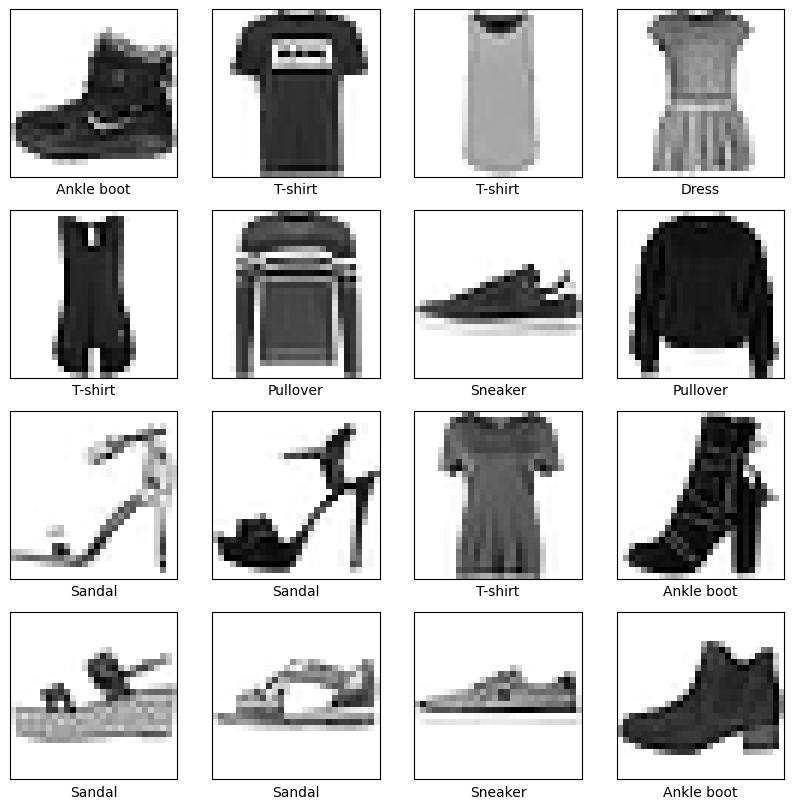

In [6]:
# store the label descriptions in a list to use in labelling the plotted images:
labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# scale the pixel intensities from 0 to 255 to 0 to 1 and reshape the flat images:
flat_sample_images = []
for i in range(16):
    flat_sample_images.append(X_train[i] / 255.0)

sample_images = []
for i in range(16):
    sample_images.append(flat_sample_images[i].reshape((28,28)))

# make figure with the 16 images
plt.figure(figsize=(10,10))
for i in range(16):
    # position subplot in a 4x4 grid
    plt.subplot(4,4,i+1)

    # hide axes ticks and grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # show images with reverse gray color map
    plt.imshow(sample_images[i], cmap='gray_r')
    
    # add labels
    plt.xlabel(labels[y_train[i]])

# show the figure
plt.show()

## Data Preprocessing

A classic approach to object recognition is HOG-PCA-SVM, which stands for Histogram of Oriented Gradients, Principal Component Analysis and Support Vector Machines:

- [HOGs](https://learnopencv.com/histogram-of-oriented-gradients/) are a feature descriptor that provides a simplified representation of an image by extracting sense of edges (useful information in image classification tasks) in the image which is not readily available information if we simply use just the (flattened) pixel intensities as the features. Basically, HOG aims for a more compact representation of an image by exploiting its local shape and appearance.

- PCA reduces dimensionality of the features, and is essential since HOGs adds lot of features. Image compression from PCA is remarkably efficient. For example, in [this article](https://www.kaggle.com/code/mirzarahim/introduction-to-pca-image-compression-example) it was shown that a reduction to just 38 components, instead of 784 pixels, could still explain 95% of the variance in the image!

- SVM algorithm works by finding the hyperplane that separates the different classes in the feature space.

Let's first visualize HOG descriptors. (In the process I will tune parameters in generating HOG images that best show gradients in the right places, for the sample images at hand):

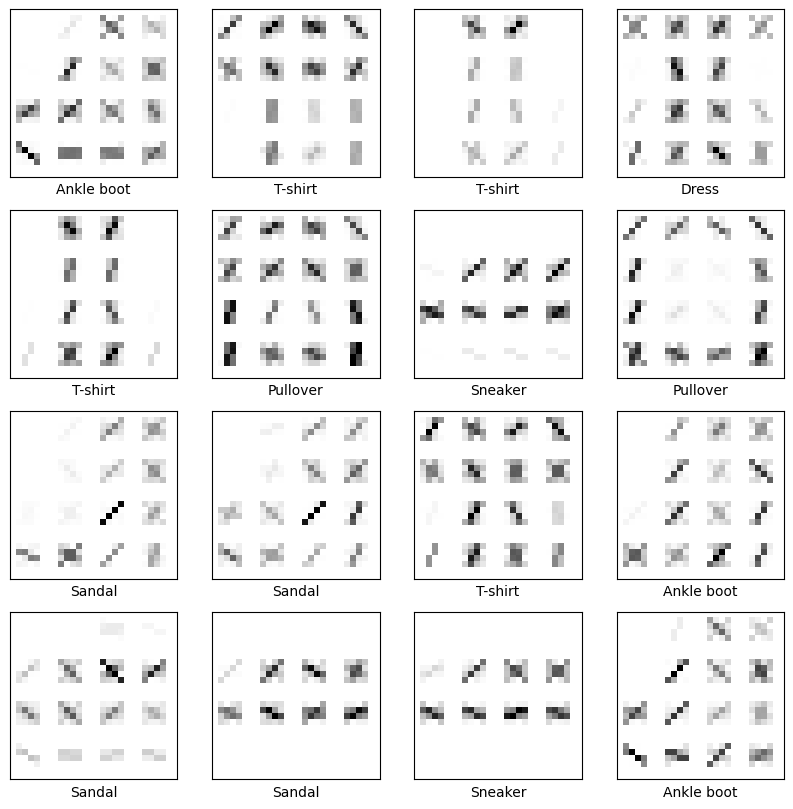

In [7]:
from skimage.feature import hog

sample_features = []

plt.figure(figsize=(10,10))
for i in range(16):
    # create HOG feature vector and image
    hog_feature , hog_image = hog(
        sample_images[i],
        orientations=8,
        pixels_per_cell=(7, 7),
        cells_per_block=(1, 1),
        visualize=True,
    )

    # append HOG feature vector to flat_sample_images (which only had pixel features)
    sample_features.append(np.concatenate((flat_sample_images[i], hog_feature), axis=0))

    # position subplot in a 4x4 grid
    plt.subplot(4,4,i+1)

    # hide axes ticks and grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # show images with reverse gray color map
    plt.imshow(hog_image, cmap='gray_r')
    
    # add labels
    plt.xlabel(labels[y_train[i]])

# show the figure
plt.show()

In [8]:
# the parameter set {orientations=8, pixels_per_cell=(7, 7), cells_per_block=(1, 1)}
# preserves enough representation while adding only 128 features.
hog_feature.shape

(128,)

Let's now use PCA to reduce dimensions of the sample images. (In the process I will tune the parameter `n_components` so that there isn't too much loss of information upon image reconstruction):

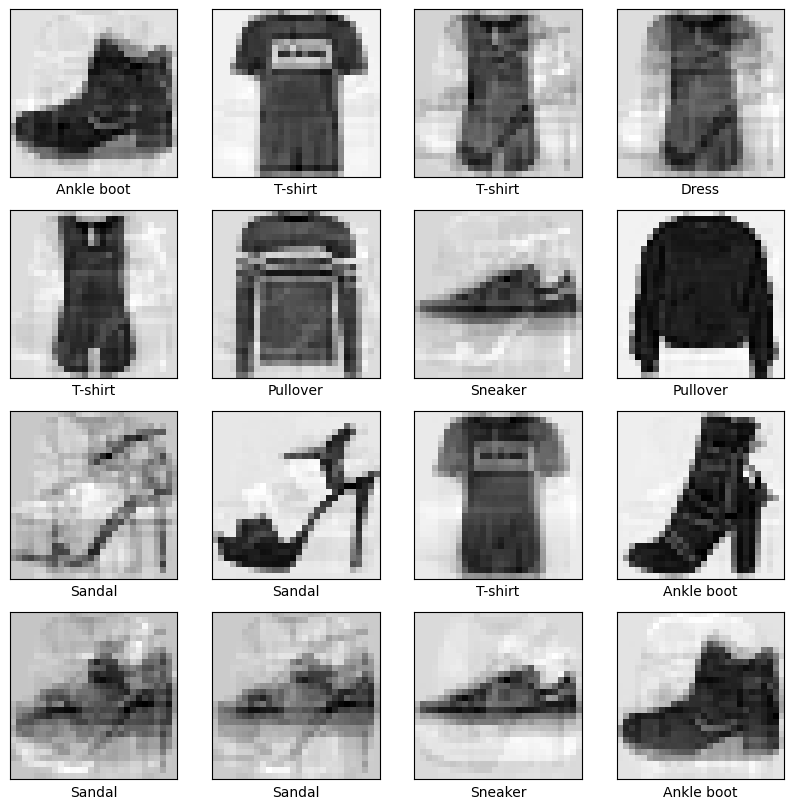

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
image_recon = pca.inverse_transform(pca.fit_transform(sample_features))

# make figure with the 16 images
plt.figure(figsize=(10,10))
for i in range(16):
    # position subplot in a 4x4 grid
    plt.subplot(4,4,i+1)

    # hide axes ticks and grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # show images with reverse gray color map
    plt.imshow(image_recon[i][:784].reshape((28,28)), cmap='gray_r')
    
    # add labels
    plt.xlabel(labels[y_train[i]])

# show the figure
plt.show()

We note that with just 8 components, which is half way the range of 0 to 14 (n_samples < n_features), we are able to notice essential distinguishing features in the reconstructions.

This means that with the full training dataset of 60k images available to PCA, we might be able to get good representation with very low n_components, which in that case shall be between 0 and 912.

Of course, we can't expect 8 components to work again on the larger dataset. This is because the wider set of images may bring in more diversity of fashion styles which tould be hard to distinguish with just 8 components. Indeed, we see this happen already for a sandal and a sneaker in bottom row of the reconstructed images.

Now, let us process 6000 samples towards for ML model input. (I manually tuned the value of n_components in PCA transformer; a better way to tune is using a [Cumulative Explained Variance plot](https://www.kaggle.com/code/mirzarahim/introduction-to-pca-image-compression-example))

In [10]:
def input_data_processor(data, step):

    data_processed = []

    # create 32-component PCA transformer
    pca = PCA(n_components=32)

    for i in range(0, len(data), step):
        # create HOG feature vector
        hog_feature = hog(
            data[i].reshape((28, 28)),
            orientations=8,
            pixels_per_cell=(7, 7),
            cells_per_block=(1, 1),
            visualize=False,
        )

        # concat HOG feature vector to the already flat image (which is actually pixel intensities as features)
        data_processed.append(np.concatenate((data[i], hog_feature), axis=0))

    # reduce to principal components via PCA
    # note: Ideally we would need the *fitted* PCA 'model' for preprossing test input data.
    #       However, we keep things simple for the exploratory model selection phase.
    #       Once we have figured out a fine tuned model, we can rewrite the code as needed.
    return pca.fit_transform(data_processed)

X_train_2 = input_data_processor(X_train, 10)

y_train_2 = [y_train[i] for i in range(0, len(X_train), 10)]

## Model Selection

**Advice**: [The general advice in choosing the right estimator](https://scikit-learn.org/stable/machine_learning_map.html) for classification task at habd is to go in order {Linear SVC -> KNeighborsClassifier -> SVC / Ensemble Classifiers} :

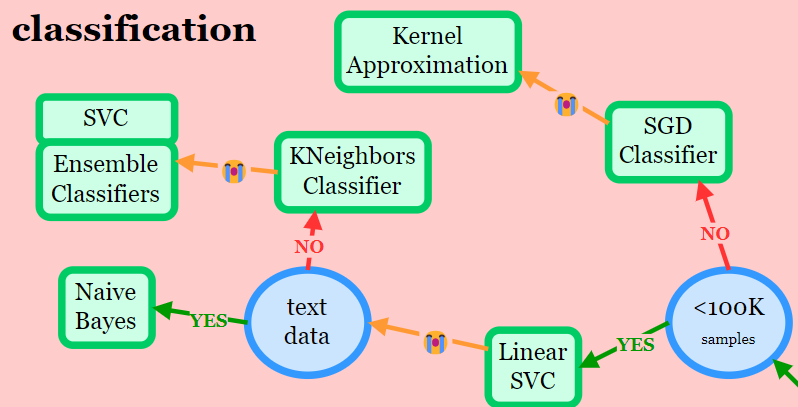

**Task**: Train a linear model and check its performance to get an idea of error with a simple model.

**Strategy**: Let's train a Linear SVC model. Since we need to compare performance of different models for model selection, I would use k-fold cross validation during the training. This way, we would have an out-of-sample error measure of various models while working within the 60k training dataset. (We'll test the performance of final fine-tuned model on the 10k test dataset separately.)

In [11]:
from sklearn.svm import LinearSVC
lin_svc = LinearSVC(random_state=42, dual='auto')

In [12]:
from sklearn.model_selection import cross_val_score

lin_svc_score = cross_val_score(lin_svc, X_train_2, y_train_2, scoring="accuracy", cv=5)
lin_svc_score.mean()

0.8118333333333332

**Observation**: There are lot of cases where the model predicts incorrectly.

**Task**: Let's look at the learning curves to check if the model is underfitting/overfitting the data.

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number 

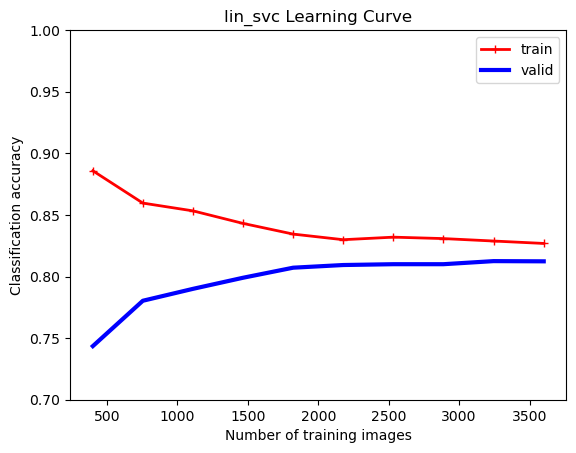

In [13]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    lin_svc, 
    X_train_2, y_train_2,
    train_sizes=np.linspace(0.1, 0.9, 10), cv=3,
    scoring="accuracy")

train_errors = train_scores.mean(axis=1)
valid_errors = valid_scores.mean(axis=1)

fig, ax = plt.subplots()
ax.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
ax.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
ax.set(xlabel='Number of training images', ylabel='Classification accuracy',
       title='lin_svc Learning Curve')
ax.legend()
ax.set_ylim(0.7, 1.0)
plt.show()

**Observation**: Indeed, the model is underfitting (since after about 2000 images, adding more images to training doesn't help much, and also since the training and validation error overlap upon saturation).

**Task**: Let's train nearest neighbor classifier.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=20)

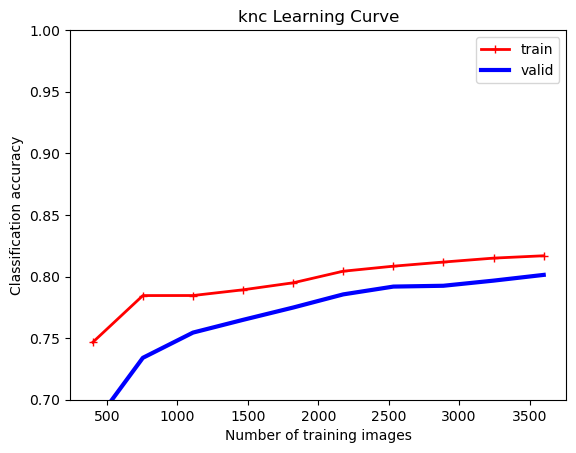

In [15]:
train_sizes, train_scores, valid_scores = learning_curve(
    knc, 
    X_train_2, y_train_2,
    train_sizes=np.linspace(0.1, 0.9, 10), cv=3,
    scoring="accuracy")

train_errors = train_scores.mean(axis=1)
valid_errors = valid_scores.mean(axis=1)

fig, ax = plt.subplots()
ax.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
ax.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
ax.set(xlabel='Number of training images', ylabel='Classification accuracy',
       title='knc Learning Curve')
ax.legend()
ax.set_ylim(0.7, 1.0)
plt.show()

**Observation**: This is slightly better as there seems promise of improvement in accuracy with more data (which we do have for later use during tuning of final model).

**Task**: Let's try a nonlinear SVC (with default RBF kernel) and an ensemble method (RandomForest).

In [16]:
from sklearn.svm import SVC
svc = SVC()

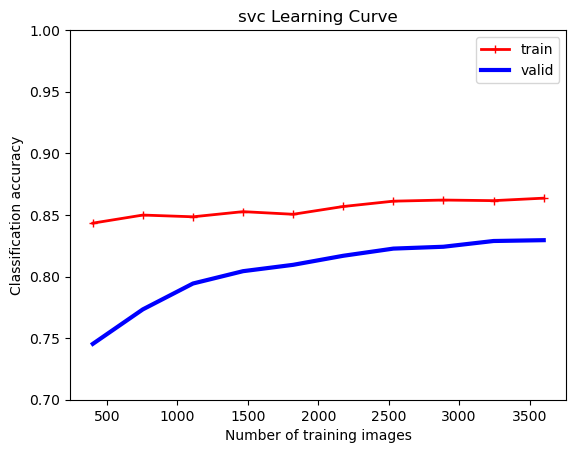

In [17]:
train_sizes, train_scores, valid_scores = learning_curve(
    svc, 
    X_train_2, y_train_2,
    train_sizes=np.linspace(0.1, 0.9, 10), cv=3,
    scoring="accuracy")

train_errors = train_scores.mean(axis=1)
valid_errors = valid_scores.mean(axis=1)

fig, ax = plt.subplots()
ax.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
ax.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
ax.set(xlabel='Number of training images', ylabel='Classification accuracy',
       title='svc Learning Curve')
ax.legend()
ax.set_ylim(0.7, 1.0)
plt.show()

**Observation**: This model performs well: the accuracy improves beyond 80% with training set size in both cases. It neither underfits nor overfits.

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_estimators=12)

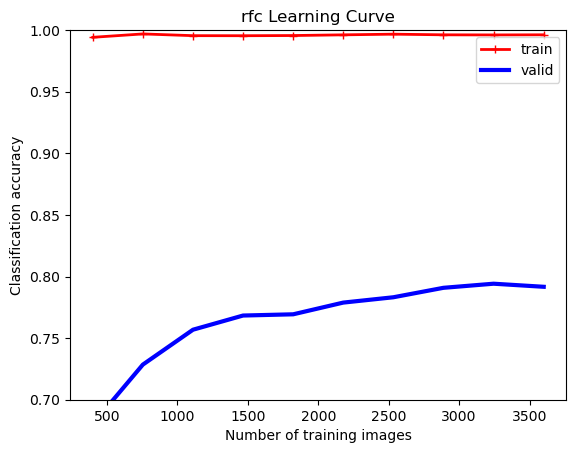

In [19]:
train_sizes, train_scores, valid_scores = learning_curve(
    rfc, 
    X_train_2, y_train_2,
    train_sizes=np.linspace(0.1, 0.9, 10), cv=3,
    scoring="accuracy")

train_errors = train_scores.mean(axis=1)
valid_errors = valid_scores.mean(axis=1)

fig, ax = plt.subplots()
ax.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
ax.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
ax.set(xlabel='Number of training images', ylabel='Classification accuracy',
       title='rfc Learning Curve')
ax.legend()
ax.set_ylim(0.7, 1.0)
plt.show()

**Observation**: This model is overfitting (since there is gap in training and validation error upon saturation).

## Training and Testing

**Task**: Train a HOG-PCA-SVC classifier on entire training dataset.

In [27]:
def hog_appender(data):
    data_processed = []

    for i in range(0, len(data)):
        # create HOG feature vector
        hog_feature = hog(
            data[i].reshape((28, 28)),
            orientations=8,
            pixels_per_cell=(7, 7),
            cells_per_block=(1, 1),
            visualize=False,
        )

        # concat HOG feature vector to the already flat image (which is actually pixel intensities as features)
        data_processed.append(np.concatenate((data[i], hog_feature), axis=0))
    
    return data_processed

# create and add HOG feature vector
X_train_processed = hog_appender(X_train)
X_test_processed = hog_appender(X_test)

In [28]:
# reduce to principal components via 64-component PCA
pca = PCA(n_components=64)
pca.fit(X_train_processed)
X_train_processed = pca.transform(X_train_processed)
X_test_processed = pca.transform(X_test_processed)

In [32]:
# train SVC model
svc = SVC(kernel='rbf')
model = svc.fit(X_train_processed, y_train)

In [30]:
# make predictions
y_predicted = model.predict(X_test_processed)

In [31]:
# score classification accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predicted)

0.8775

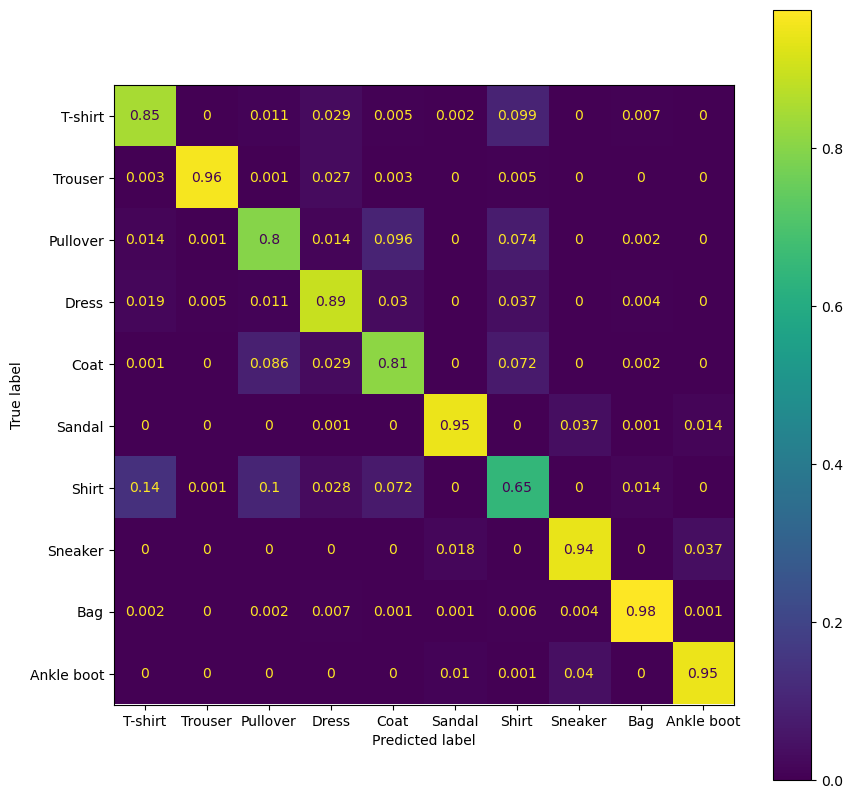

In [41]:
# inspect classification confusions

from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, normalize='true', display_labels=labels, ax=ax)
plt.show()

**Observation:** The model is most confused among T-shirt, Pullover, and Coat. There is small confusion among Trouser, Sandal, Sneaker, Ankle boot and Bag.

**Conclusion**:

Finally, we have a fine-tuned HOG-PCA-SVC classifier with hyperparameters as follows:
- HOG : pixels_per_cell=(7, 7)
- HOG : cells_per_block=(1, 1)
- PCA : n_components = 64
- SVC : kernel = 'rbf'

The classification accuracy with this model is **88%**.

This is [better than human performance of **84%**](https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file#:~:text=%F0%9F%94%97-,Human%20Performance,-Crowd%2Dsourced%20evaluation) on the dataset.